In [86]:
import pandas as pd

In [87]:
from pathlib import Path # https://realpython.com/python-pathlib/

# TODO: Check if this also works in vs code!
parent_path = Path.cwd().parent
train_path = parent_path.joinpath("dataset", "formatted_train.csv")
test_path = parent_path.joinpath("dataset", "formatted_test.csv")

train_df = pd.read_csv(test_path)
test_df = pd.read_csv(test_path)
test_df.head()

,sentiment,title,body
0,negative,mens ultrasheer,"This model may be ok for sedentary types, but ..."
1,positive,Surprisingly delightful,This is a fast read filled with unexpected hum...
2,negative,"Works, but not as advertised",I bought one of these chargers..the instructio...
3,negative,Oh dear,I was excited to find a book ostensibly about ...
4,negative,Incorrect disc!,"I am a big JVC fan, but I do not like this mod..."


In [88]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression

In [89]:
# Get data
text_train = train_df[["title", "body"]]
y_train = train_df["sentiment"]

text_test = test_df[["title", "body"]]
y_test = test_df["sentiment"]

text_test.head()

,title,body
0,mens ultrasheer,"This model may be ok for sedentary types, but ..."
1,Surprisingly delightful,This is a fast read filled with unexpected hum...
2,"Works, but not as advertised",I bought one of these chargers..the instructio...
3,Oh dear,I was excited to find a book ostensibly about ...
4,Incorrect disc!,"I am a big JVC fan, but I do not like this mod..."


In [90]:
y_test.head()

0    negative
1    positive
2    negative
3    negative
4    negative
Name: sentiment, dtype: object

**The following code is primarily from https://www.kaggle.com/code/kashnitsky/topic-4-linear-models-part-4-pros-cons which was used as a reference in our proposal.**

In [94]:
cv = CountVectorizer()
text_train = text_train["body"]
cv.fit(text_train) # Figure out later how we handle titles
len(cv.vocabulary_)

290454

In [96]:
print(cv.get_feature_names_out()[:50])
print(cv.get_feature_names_out()[50000:50050])

['00' '000' '0000' '00000' '000000' '000000000'
 '00000000000000000000000000001' '000000000000000000000000008' '000000001'
 '0000001' '000001' '00001' '000013' '00001a' '00002' '00005' '0001'
 '000100' '0002' '00023' '00027' '0003' '0005' '000540' '0006' '000726'
 '0007made' '00091' '000_' '000bc' '000btu' '000ft' '000hp' '000hz' '000k'
 '000km' '000lb' '000lbs' '000ma' '000new' '000one' '000rpm' '000s'
 '000th' '000v' '000vit' '000x' '000xxxxxif' '001' '00101']
['catspaw' 'catsplay' 'catstop' 'catsuit' 'catsuits' 'catsup' 'catt'
 'catta' 'cattagorize' 'cattan' 'cattaneo' 'cattani' 'catted' 'catteneo'
 'catteni' 'catterpillar' 'catterwailing' 'catterwolling' 'cattery'
 'catthe' 'cattibrie' 'cattie' 'cattiness' 'catting' 'cattivo' 'cattle'
 'cattlemen' 'cattlesman' 'cattleya' 'cattleyas' 'cattolica' 'catton'
 'cattrail' 'cattral' 'cattrall' 'catttle' 'catty' 'catudal' 'catullus'
 'catured' 'caturla' 'catv' 'catwalk' 'catwalkif' 'catwalks' 'catwaomen'
 'catwoman' 'catwomen' 'caty' 'catz'

In [97]:
# encode reviews with indices of incomming words
X_train = cv.transform(text_train)
X_train

<520000x290454 sparse matrix of type '<class 'numpy.int64'>'
	with 27695029 stored elements in Compressed Sparse Row format>

In [98]:
# Visualizing transformation
print(text_train[19726])

They hardly rock and can't even really pull off disco. They can't touch the bands they try to emulate. The singer is weak and annoying. This band is overrated.


In [99]:
X_train[19726].nonzero()[1]

array([ 20320,  21643,  31267,  31342,  47339,  77995,  88796,  93163,
       119022, 136571, 181751, 186940, 205333, 210312, 219219, 233911,
       256046, 257683, 258113, 260623, 262254, 265417, 279924])

In [100]:
X_train[19726].nonzero()

(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0]),
 array([ 20320,  21643,  31267,  31342,  47339,  77995,  88796,  93163,
        119022, 136571, 181751, 186940, 205333, 210312, 219219, 233911,
        256046, 257683, 258113, 260623, 262254, 265417, 279924]))

In [101]:
# Transform test set
X_test = cv.transform(text_test)

In [104]:
%%time
# Logistic regression time!
logit = LogisticRegression(solver="lbfgs", n_jobs=-1, random_state=7)
logit.fit(X_train, y_train)

CPU times: total: 1.62 s
Wall time: 29.7 s


LogisticRegression(n_jobs=-1, random_state=7)

In [107]:
round(logit.score(X_train, y_train), 3), round(logit.score(X_test, y_test), 3),

(0.877, 0.877)

Visualization

In [108]:
def visualize_coefficients(classifier, feature_names, n_top_features=25):
    # get coefficients with large absolute values
    coef = classifier.coef_.ravel()
    positive_coefficients = np.argsort(coef)[-n_top_features:]
    negative_coefficients = np.argsort(coef)[:n_top_features]
    interesting_coefficients = np.hstack([negative_coefficients, positive_coefficients])
    # plot them
    plt.figure(figsize=(15, 5))
    colors = ["red" if c < 0 else "blue" for c in coef[interesting_coefficients]]
    plt.bar(np.arange(2 * n_top_features), coef[interesting_coefficients], color=colors)
    feature_names = np.array(feature_names)
    plt.xticks(
        np.arange(1, 1 + 2 * n_top_features),
        feature_names[interesting_coefficients],
        rotation=60,
        ha="right",
    )

In [109]:
def plot_grid_scores(grid, param_name):
    plt.plot(
        grid.param_grid[param_name],
        grid.cv_results_["mean_train_score"],
        color="green",
        label="train",
    )
    plt.plot(
        grid.param_grid[param_name],
        grid.cv_results_["mean_test_score"],
        color="red",
        label="test",
    )
    plt.legend()

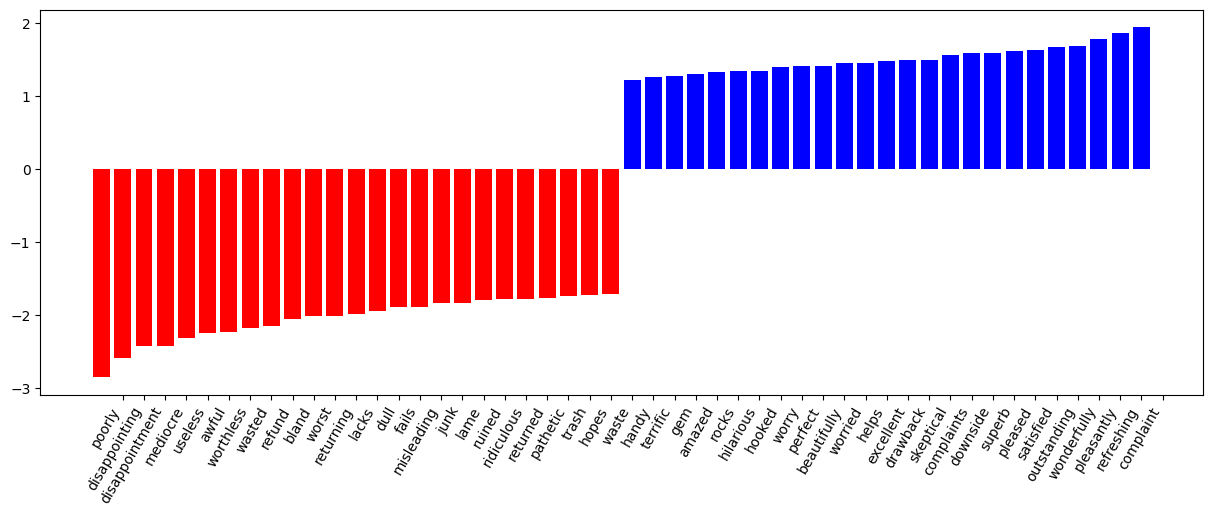

In [111]:
visualize_coefficients(logit, cv.get_feature_names_out())

In [112]:
# From Kaggle "To make our model better, we can optimize the regularization coefficient for the Logistic Regression. We'll use sklearn.pipeline because CountVectorizer should only be applied to the training data (so as to not "peek" into the test set and not count word frequencies there). In this case, pipeline determines the correct sequence of actions: apply CountVectorizer, then train Logistic Regression."

from sklearn.pipeline import make_pipeline

text_pipe_logit = make_pipeline(
    CountVectorizer(),
    # for some reason n_jobs > 1 won't work
    # with GridSearchCV's n_jobs > 1
    LogisticRegression(solver="lbfgs", n_jobs=1, random_state=7),
)

text_pipe_logit.fit(text_train, y_train)
print(text_pipe_logit.score(text_test, y_test))

C:\Users\freja\Desktop\ECE539-Final-Project\venv\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.8768576923076923


In [116]:
%%time
from sklearn.model_selection import GridSearchCV

param_grid_logit = {"logisticregression__C": np.logspace(-5, 0, 6)}
grid_logit = GridSearchCV(
    text_pipe_logit, param_grid_logit, return_train_score=True, cv=3, n_jobs=-1
)

grid_logit.fit(text_train, y_train)

PicklingError: Could not pickle the task to send it to the workers.

In [114]:
grid_logit.best_params_, grid_logit.best_score_

AttributeError: 'GridSearchCV' object has no attribute 'best_params_'

In [ ]:
plot_grid_scores(grid_logit, "logisticregression__C")

In [ ]:
grid_logit.score(text_test, y_test)